In [98]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize,BoundaryNorm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from scipy.sparse import csr_matrix
from scipy.ndimage import generic_filter
import random

In [150]:
 class population():
    def __init__(self,N = 100,duration = 100,transmission_time = 7,imunity_time = 7,r_0 = 0.01,infection_rate = 0.3,mortality_rate = 0.03,sociability = 4,daily_contact_rate = 0.5):
        self.N = N                             # defining all parameters and initializing the world
        self.duration = duration
        self.transmission_time = transmission_time
        self.imunity_time = imunity_time
        self.sociability = sociability
        self.mortality_rate = mortality_rate
        self.daily_contact_rate = daily_contact_rate
        self.r_0 = r_0
        self.infection_rate = infection_rate
        self.history = []
        self.per = []
        self.death = []
        self.world = np.zeros((N, N), dtype=[('health', 'float32'), ('status', 'uint8'), ('timer', 'int32')])
        self.world['health'] = np.random.uniform(0.5, 1, (N, N))
        self.world['timer'] = -imunity_time   # the world is created through a two dimensional structered array with the three fields healt,status,timer
        for _ in range(round(r_0*N**2)):  
            i,j = np.random.randint(N),np.random.randint(N)
            self.world['status'][i,j] = 1   # set status
            self.world['timer'][i,j] = self.transmission_time # set time to transmit disease
        self.infection_chance_matrices = [np.random.uniform(0, 0.5, (2 * self.sociability + 1, 2 * self.sociability + 1)) for _ in range(3000)]
    def sim(self):
        %matplotlib notebook
        t = 0
        dt = 1
        while t < self.duration:
            infected_indices = np.where(self.world['status'] == 1)
            for x,y in zip(*infected_indices):
                if (x >= self.sociability and y >= self.sociability) and (x <= self.N-self.sociability and y <= self.N-self.sociability):
                    start_y = y - self.sociability
                    end_y = y + self.sociability + 1
                    start_x = x - self.sociability
                    end_x = x + self.sociability + 1
                else:
                    start_y = max(y - self.sociability, 0)
                    end_y = min(y + self.sociability + 1, self.world.shape[0])
                    start_x = max(x - self.sociability, 0)
                    end_x = min(x + self.sociability + 1, self.world.shape[1])
                sub_world = self.world[start_y:end_y, start_x:end_x]
                health_matrix, status_matrix, recovery_matrix = sub_world['health'], sub_world['status'], sub_world['timer']  # Get the recovery time sub-matrix
                susceptible_condition = (status_matrix == 0) & (recovery_matrix < -self.imunity_time) & (np.random.uniform(0, 1, status_matrix.shape) < self.daily_contact_rate)
                infection_chance_matrix = random.choice(self.infection_chance_matrices)[:health_matrix.shape[0], :health_matrix.shape[1]]
                infection_chance = health_matrix - infection_chance_matrix  # Apply the random transmission factor
                new_infections = (infection_chance < self.infection_rate) & susceptible_condition
                new_diseased = (infection_chance < self.infection_rate*self.mortality_rate) & susceptible_condition
                status_matrix[new_infections] = 1
                recovery_matrix[new_infections] = self.transmission_time
                status_matrix[new_diseased] = 2                   
            self.world['timer'] -= 1
            self.world['status'][(self.world['status'] == 1) & (self.world['timer'] < 0)] = 0
            self.history.append(csr_matrix(self.world['status']))
            death_tally = np.sum(self.world['status'] == 2)
            self.per.append(np.sum(self.world['status'] == 1) / (self.N*self.N - death_tally) * 100)
            self.death.append(death_tally/(self.N*self.N) * 100)
            t += dt

        #Animation 
        cmap = ListedColormap(['white', 'red', 'black'])
        norm = BoundaryNorm([0, 1, 2, 3], cmap.N) 
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [3, 1, 1]})
        gs = GridSpec(1, 3, width_ratios=[8, 1, 1])
        ax1,ax2,ax3 = plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])
        plot = ax1.imshow(self.history[0].toarray(), cmap=cmap, norm=norm)
        time_text = ax1.text(0.4,  1.05, '', transform=ax1.transAxes, color='black')
        for ax in (ax1,ax2,ax3):
            ax.set_xticks([])
            ax.set_yticks([])
        infected_bar = ax2.bar(0, 0, color='red')
        diseased_bar = ax3.bar(0, 0, color='black')
        ax2.set_ylim(0, 100), ax3.set_ylim(0, 100)
        ax2.set_title('Infected (%)',fontsize=7), ax3.set_title('Diseased (%)',fontsize=7)
        def animate(i):
            plot.set_data(self.history[i].toarray())
            time_text.set_text('Day:  %.1f' % i )
            bar_inf = infected_bar[0]
            bar_dis = diseased_bar[0]
            bar_inf.set_height(self.per[i])
            bar_dis.set_height(self.death[i])
            return plot, time_text, bar_inf,bar_dis
        animation = FuncAnimation(fig,
                              func = animate,
                              frames = np.arange(len(self.history)), 
                              interval = 150)
        return animation

<IPython.core.display.Javascript object>


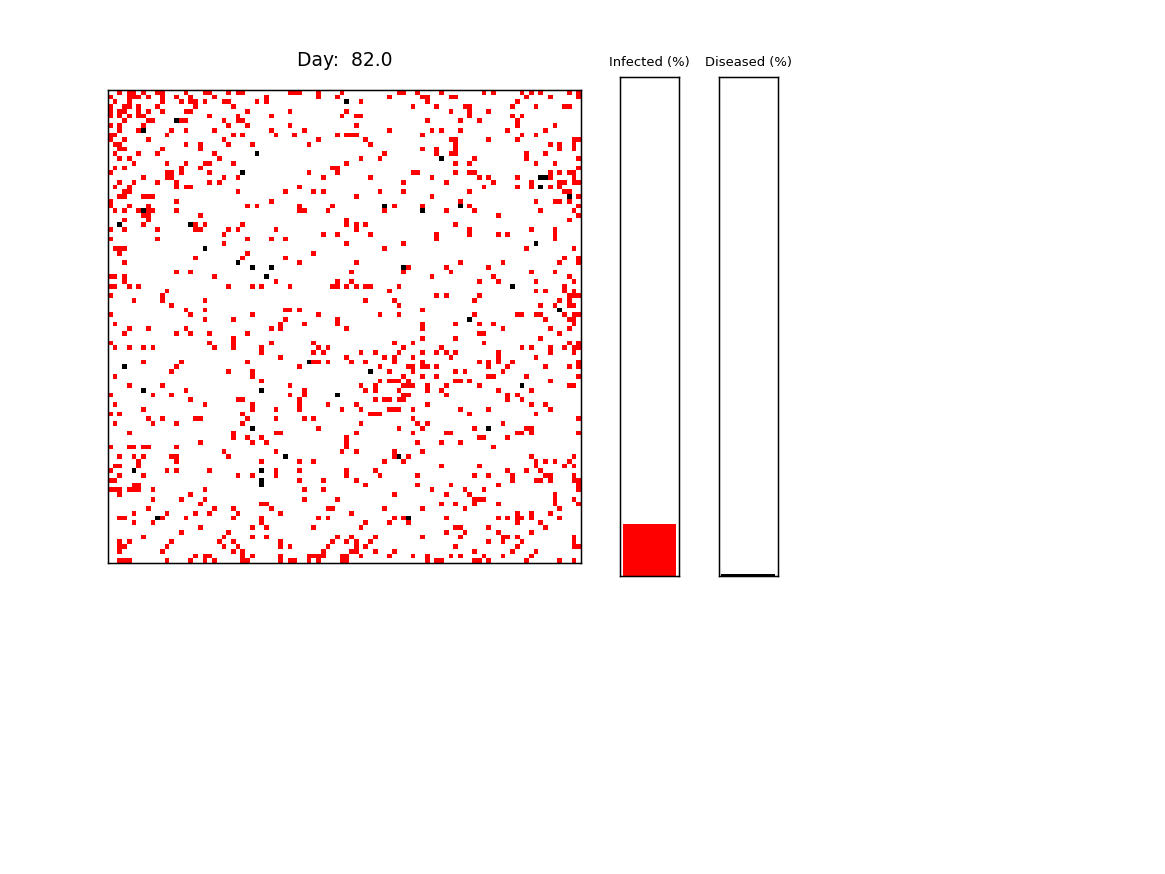

In [133]:
example = population(N = 100, duration = 100, r_0 = 0.01, infection_rate = 0.3, transmission_time=7, 
                  imunity_time=7, sociability = 5, mortality_rate = 0.05,daily_contact_rate=0.1)

example.sim()

# Profiler

<IPython.core.display.Javascript object>


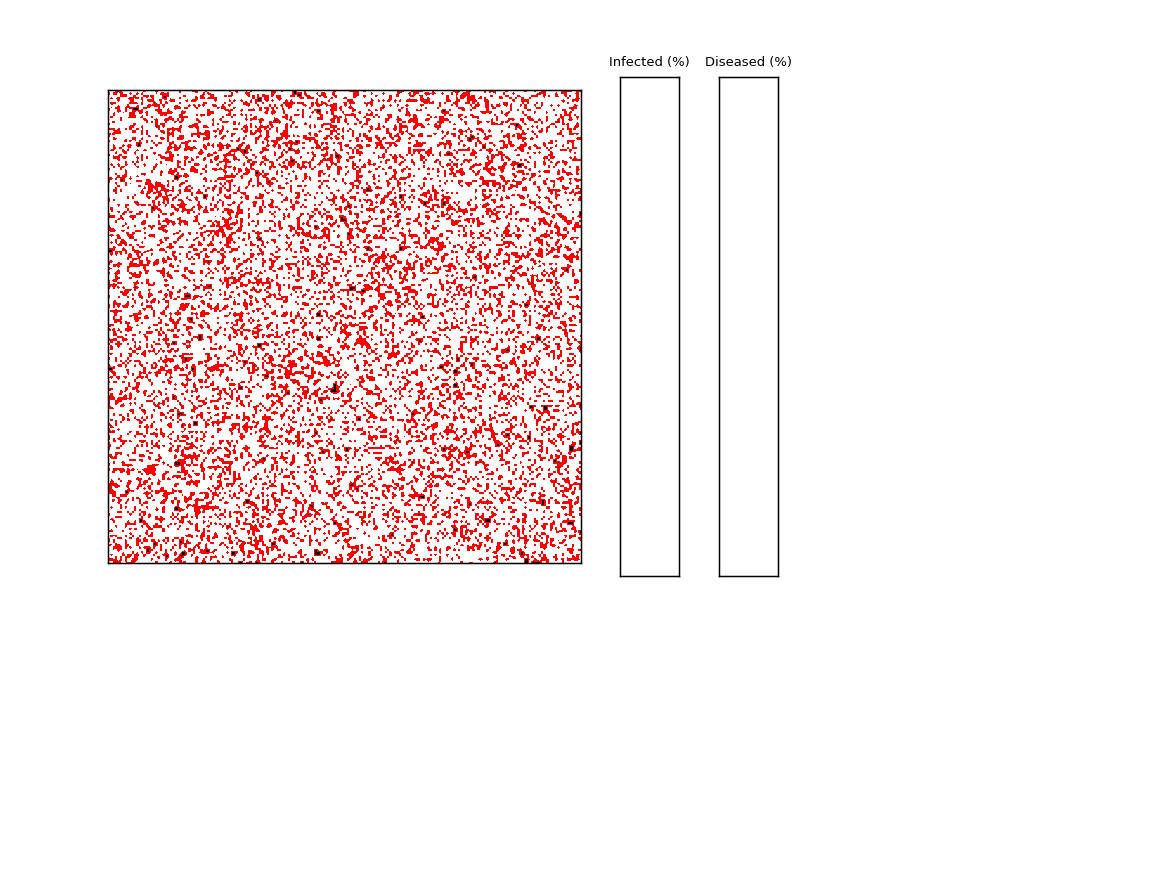

         4470010 function calls (4466934 primitive calls) in 15.345 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   11.954   11.954   15.344   15.344 <ipython-input-147-142d2c5c9b59>:23(sim)
   645454    2.001    0.000    2.001    0.000 {method 'uniform' of 'numpy.random.mtrand.RandomState' objects}
   645454    0.383    0.000    0.994    0.000 random.py:285(choice)
   645454    0.378    0.000    0.536    0.000 random.py:250(_randbelow_with_getrandbits)
     1939    0.184    0.000    0.194    0.000 inspect.py:2901(_bind)
   880710    0.095    0.000    0.095    0.000 {method 'getrandbits' of '_random.Random' objects}
   646789    0.075    0.000    0.075    0.000 {built-in method builtins.len}
   645454    0.063    0.000    0.063    0.000 {method 'bit_length' of 'int' objects}
    60358    0.024    0.000    0.024    0.000 {built-in method builtins.max}
1363/1123    0.020    0.000    0.037    0.000 {built-in method

       92    0.000    0.000    0.000    0.000 {built-in method math.radians}
       58    0.000    0.000    0.000    0.000 transforms.py:200(<lambda>)
        4    0.000    0.000    0.001    0.000 threading.py:270(wait)
     16/8    0.000    0.000    0.000    0.000 transforms.py:2320(__eq__)
       84    0.000    0.000    0.000    0.000 axis.py:368(<dictcomp>)
       84    0.000    0.000    0.000    0.000 axis.py:381(<dictcomp>)
        5    0.000    0.000    0.000    0.000 inspect.py:2772(__init__)
        3    0.000    0.000    0.003    0.001 __init__.py:1444(inner)
        6    0.000    0.000    0.002    0.000 figure.py:2067(sca)
        1    0.000    0.000    0.001    0.001 _axes.py:5328(imshow)
        2    0.000    0.000    0.000    0.000 formatters.py:689(__call__)
       24    0.000    0.000    0.000    0.000 artist.py:711(set_clip_box)
       16    0.000    0.000    0.000    0.000 hmac.py:130(hexdigest)
        6    0.000    0.000    0.001    0.000 _base.py:965(_gen_axes_patch

        1    0.000    0.000    0.000    0.000 backend_webagg_core.py:523(_timer_stop)
        1    0.000    0.000    0.000    0.000 backend_webagg_core.py:533(_timer_set_interval)
        2    0.000    0.000    0.000    0.000 {method 'keys' of 'dict' objects}
        1    0.000    0.000    0.000    0.000 {method 'move_to_end' of 'collections.OrderedDict' objects}
        1    0.000    0.000    0.000    0.000 {method 'strip' of 'str' objects}
        1    0.000    0.000    0.000    0.000 {built-in method sys._getframe}
        1    0.000    0.000    0.000    0.000 backend_bases.py:1184(_timer_set_single_shot)
        1    0.000    0.000    0.000    0.000 argparse.py:1676(identity)
        1    0.000    0.000    0.000    0.000 interactiveshell.py:706(get_ipython)
        1    0.000    0.000    0.000    0.000 {built-in method _json.encode_basestring_ascii}




In [149]:
import cProfile
example = population(N = 200, duration = 100, r_0 = 0.01, infection_rate = 0.3, transmission_time=7, 
                  imunity_time=7, sociability = 3, mortality_rate = 0.5)
profiler = cProfile.Profile()
profiler.enable()
example.sim()
profiler.disable()
# Display results
profiler.print_stats(sort='time')